<a href="https://colab.research.google.com/github/FraCorti/AI_Project/blob/master/spamFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Added **Kaggle** installation and downloading *spam.csv* dataset from the following link: [spam-collection-dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)

In [56]:
!pip install kaggle
!mkdir /root/.kaggle
!echo '{"username":"fcorti","key":"fafa72652d9ae6ee3bab07bad5a1a96c"}' > /root/.kaggle/kaggle.json
!kaggle datasets download -d uciml/sms-spam-collection-dataset
!pip install pandas
!pip install -q tensorflow_data_validation

import tensorflow_data_validation as tfdv
import pandas as pd
import tensorflow as tf

from zipfile import ZipFile

mkdir: cannot create directory ‘/root/.kaggle’: File exists
sms-spam-collection-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


Imported **pandas** and convert the *sms-spam-collection-dataset.zip* file into *.csv* format


In [57]:
zip_file = ZipFile('/content/sms-spam-collection-dataset.zip')
data = pd.read_csv(zip_file.open('spam.csv'), encoding = "latin-1")
data = data.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)
data = data.rename(columns={"v1":'label', "v2":'text'})
tags = data["label"]
texts = data["text"]  
print("Dataset shape: ", data.shape)

Dataset shape:  (5572, 2)


Save the dataset **locally** to allow viewing by clicking on it: 

In [0]:
data.to_csv(r'/content/spam.csv', index = None, header = True)

Dataset **statistics**: 

In [59]:
train_stats = tfdv.generate_statistics_from_csv(data_location = '/content/spam.csv')
tfdv.visualize_statistics(train_stats)

**Divided data** into training set and test set: 

1.   List item
2.   List item



In [60]:
!pip install sklearn

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import metrics

num_max = 1000  # calcolare le medie e capire meglio il pre-processing  dei dati, paragonare risultati ottenuti rete con altri in internet
le = LabelEncoder()  # analizzare le metriche di cosa sta succedendo 
tags = le.fit_transform(tags) # provare a semplificare rete neurale e vedere cosa succede effettivamente (mostrare accuratezza nel test set)
# print(tags.shape)  # fare breve report (relazione dove spieghiamo cosa facciamo)
# confronto con diversi tipi di algoritmi di apprendimento quanto "imparano" attenzione ad usare lo stesso dataser"
tokenizer = Tokenizer(num_words = num_max)  # allows to vectorize a text corpus, by turning each text into either a sequence of integers or into a vector.
tokenizer.fit_on_texts(texts) # updates internal vocabulary based on a list of texts. Creates the vocabulary index based on word frequency.
mat_texts = tokenizer.texts_to_matrix(texts, mode = 'count')  # count: the count of each word in the document.

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(texts , tags, test_size = 0.2)
mat_texts_tr = tokenizer.texts_to_matrix(x_train, mode = 'count')
mat_texts_tst = tokenizer.texts_to_matrix(x_test, mode = 'count')

print (x_train.shape, y_train.shape) # print the train dataset shape 
print (x_test.shape, y_test.shape)   # print the test dataset shape

(4457,) (4457,)
(1115,) (1115,)


Create the  **Sequential Keras** model, more info at ["The Sequential model API"](https://keras.io/models/sequential/). \\
More info about the *Dropout technique* can be found in the following paper: ["Dropout: A Simple Way to Prevent Neural Networks from
Overfitting"](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)

In [61]:
    model = Sequential()   # model type 
    model.add(Dense(512, activation = 'relu', input_dim = num_max)) # first layer need to receive information about its input shape, num_max 
    model.add(Dropout(0.2))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.summary()      

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 512)               512512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 644,097
Trainable params: 644,097
Non-trainable params: 0
_________________________________________________________________


**Configure** the learning process, more info at ["Compilation"](https://keras.io/getting-started/sequential-model-guide/#compilation)

In [0]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc',metrics.binary_accuracy]) 

**Display** the model and saves it in a *.png* format file 

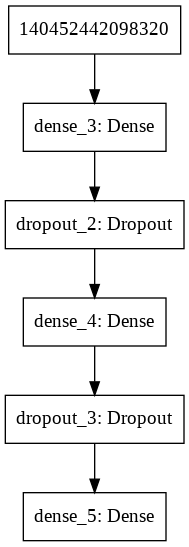

In [63]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file = 'model.png')
Image('model.png')

**Training** the model with the 80% of the spam dataset, more info at  ["Training"](https://keras.io/getting-started/sequential-model-guide/#training) 

In [64]:
    # verbose:  shows the progress bar during training see keras documentation for more info 
    # batch size: defines the number of samples that will be propagated through the network
    # epochs: iterations on a dataset
    
    history = model.fit(mat_texts_tr, y_train, batch_size = 32, epochs = 10, verbose = 1, validation_split = 0.2)

Train on 3565 samples, validate on 892 samples
Epoch 1/10
3565/3565 [==============================] - 2s 483us/sample - loss: 0.1752 - acc: 0.9467 - binary_accuracy: 0.9467 - val_loss: 0.0422 - val_acc: 0.9899 - val_binary_accuracy: 0.9899
Epoch 2/10
3565/3565 [==============================] - 1s 403us/sample - loss: 0.0372 - acc: 0.9910 - binary_accuracy: 0.9910 - val_loss: 0.0266 - val_acc: 0.9910 - val_binary_accuracy: 0.9910
Epoch 3/10
3565/3565 [==============================] - 1s 416us/sample - loss: 0.0102 - acc: 0.9978 - binary_accuracy: 0.9978 - val_loss: 0.0290 - val_acc: 0.9877 - val_binary_accuracy: 0.9877
Epoch 4/10
3565/3565 [==============================] - 1s 410us/sample - loss: 0.0030 - acc: 0.9997 - binary_accuracy: 0.9997 - val_loss: 0.0256 - val_acc: 0.9865 - val_binary_accuracy: 0.9865
Epoch 5/10
3565/3565 [==============================] - 1s 402us/sample - loss: 8.0177e-04 - acc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 0.0301 - val_acc: 0.9910 - val_bin

**Test** the neural network with the test data:

In [65]:
  model.evaluate(mat_texts_tst, y_test)

1115/1115 [==============================] - 0s 76us/sample - loss: 0.0566 - acc: 0.9883 - binary_accuracy: 0.9883


[0.05662626688693394, 0.9883408, 0.9883408]

Plot **training** and **validation** accuracy values

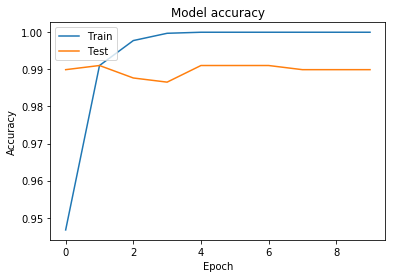

In [66]:
!pip install matplotlib

import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Plot **training** and **validation** loss values:

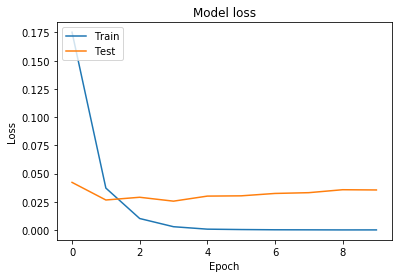

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [68]:
#Seguendo https://realpython.com/python-keras-text-classification/
data.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [0]:
sentences = data['text'].values
y = data['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)

In [70]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [71]:
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)
X_train

<4179x7388 sparse matrix of type '<class 'numpy.int64'>'
	with 55014 stored elements in Compressed Sparse Row format>

In [72]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

#Fino a https://realpython.com/python-keras-text-classification/

Accuracy: 0.9798994974874372


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
